## Setup

In [1]:
import pandas as pd  #fundamental package for data analysis
import numpy as np   #fundamental package for scientific computing
from scipy.stats import chi2_contingency #package for chi2 test
from scipy.special import expit #Vectorized sigmoid function
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split # package to split the data in a training and crossvalidation set
from sklearn.model_selection import GridSearchCV # package to search and find the best hyperparameters on the model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt  # Data visualization
get_ipython().magic('matplotlib inline')

In [2]:
# Read in data
df = pd.read_csv("/Users/wiseer85/Desktop/train_data.csv_fixed")

In [3]:
# Clean data of "nan" values
df.isnull().sum() 

user_id     0
channel     0
age         0
os          0
gender      0
country     0
customer    0
dtype: int64

In [4]:
# Show first five rows
df.head() 

,user_id,channel,age,os,gender,country,customer
0,100000,00 Organic,20,ios,female,GB,0
1,100001,00 Organic,30,ios,female,US,1
2,100002,31 OUTBRAIN,35,ios,female,DE,0
3,100003,00 Organic,26,android,female,US,0
4,100004,32 Taboola,55,ios,female,US,1


In [5]:
# Attribute summary
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82908 entries, 0 to 82907
Data columns (total 7 columns):
user_id     82908 non-null int64
channel     82908 non-null object
age         82908 non-null int64
os          82908 non-null object
gender      82908 non-null object
country     82908 non-null object
customer    82908 non-null int64
dtypes: int64(3), object(4)
memory usage: 4.4+ MB


In [6]:
# Numerical attributes summary statistics
df.describe() 

,user_id,age,customer
count,82908.000000,82908.000000,82908.000000
mean,141453.500000,31.151734,0.297848
std,23933.622396,11.596902,0.457315
min,100000.000000,12.000000,0.000000
25%,120726.750000,22.000000,0.000000
50%,141453.500000,29.000000,0.000000
75%,162180.250000,38.000000,1.000000
max,182907.000000,96.000000,1.000000


## Data Description and Visualization

(array([0, 1]), <a list of 2 Text xticklabel objects>)

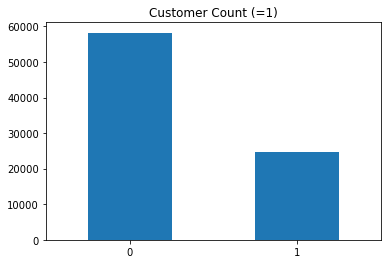

In [7]:
# Plot customer counts (ie. Dependent Variable)
plt.plot()
df['customer'].value_counts().plot(kind='bar', title='Customer Count (=1)')
plt.xticks(rotation=0)

30% of all subscribers in the data are customers (n≈25,000). In the following sections,  I explore attributes in the data and calculate the conversion rate from subscriber to customer for each attribute. 

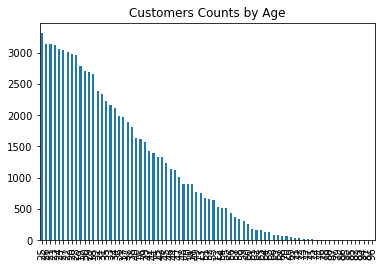

In [8]:
# Plot age counts
plt.plot()
df['age'].value_counts().plot(kind='bar', title='Customers Counts by Age')

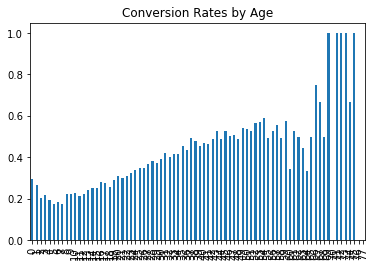

In [9]:
# Calculate conversion rate by age
p = df.pivot_table(index='age', values='customer', aggfunc={'customer': ['count', 'mean']}).reset_index()

# Plot conversion rates by age
plt.plot()
p['mean'].plot(kind='bar', title='Conversion Rates by Age')

Customers range from 12-96 years of age, although the majority are between ages 20-40. The sample drops below n=250 after age 65. Furthermore, the relationship between frequency counts and conversion rates is inverse. While young people are more likely to be customers, there is a stronger conversion rate amongst older demographics.

,gender,count,%,conversion rate
1,male,25877,0.312117,0.311
0,female,57031,0.687883,0.292


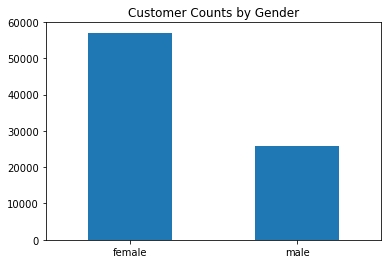

In [10]:
# Plot gender counts
plt.plot()
df['gender'].value_counts().plot(kind='bar', title='Customer Counts by Gender')
plt.xticks(rotation=0)

# Calculate conversion rate by gender
p = df.pivot_table(index='gender', values='customer', aggfunc={'customer': ['count', 'mean']}).reset_index()
p['gen_con'] = p['count'] / p['count'].sum()    

# Create pivot table with counts
p = p[['gender', 'count', 'gen_con', 'mean']]
p.rename(index=str, columns={'mean': 'conversion rate', 'gen_con': '%'}, inplace=True)
display(p.round({'gen_con': 3, 'conversion rate': 3}).sort_values(by='conversion rate', ascending=False))

Compared to men, women are more than twice as likely to be customers (70% of all customers), although the conversion rate for men and women is the same (30%). Sampling techniques may be considered in modeling.

(0.0, 1.0, 0, array([ 0.41306026,  0.58693974]))


,os,count,%,conversion rate
1,ios,48662,0.58694,0.314
0,android,34246,0.41306,0.276


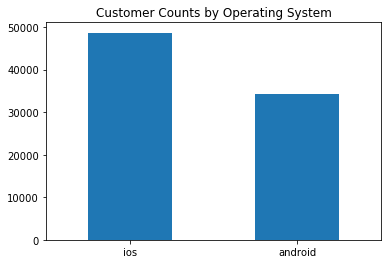

In [11]:
# Plot os counts
plt.plot()
df['os'].value_counts().plot(kind='bar', title='Customer Counts by Operating System')
plt.xticks(rotation=0)

# Calculate conversion rate by os
p = df.pivot_table(index='os', values='customer', aggfunc={'customer': ['count', 'mean']}).reset_index()
p['os_con'] = p['count'] / p['count'].sum()    

# Chi2 test for independence
print(chi2_contingency(p['os_con']))

# Create pivot table with counts
p = p[['os', 'count', 'os_con', 'mean']]
p.rename(index=str, columns={'mean': 'conversion rate', 'os_con': '%'}, inplace=True)
display(p.round({'os_con': 3, 'conversion rate': 3}).sort_values(by='conversion rate', ascending=False))

Although customers are slightly higher ios users, the conversion rate is roughly the same. This attribute may have less to relevance regarding conversion, but it might be a good control variable for the model.

,channel,count,%,conversion rate
6,32 Taboola,2789,0.033640,0.457
5,31 OUTBRAIN,6237,0.075228,0.426
11,69 Others,876,0.010566,0.352
12,95 LAT,7043,0.084950,0.333
0,00 Organic,21795,0.262882,0.302
2,12 PINTEREST,13564,0.163603,0.297
9,61 Web/Content,390,0.004704,0.295
3,21 ASA,2108,0.025426,0.278
8,42 Adcolony,4806,0.057968,0.269
1,11 FB,8857,0.106829,0.250


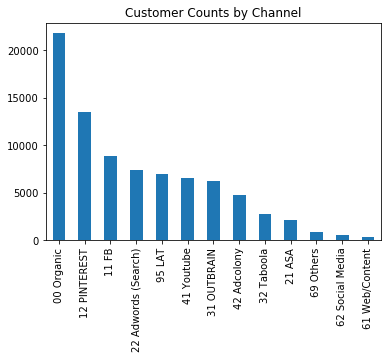

In [12]:
# Plot channel counts
plt.plot()
df['channel'].value_counts().plot(kind='bar', title='Customer Counts by Channel')

# Calculate conversion rate by channel
p = df.pivot_table(index='channel', values='customer', aggfunc={'customer': ['count', 'mean']}).reset_index()
p['chan_con'] = p['count'] / p['count'].sum()    

# Create pivot table with counts 
p = p[['channel', 'count', 'chan_con', 'mean']]
p.rename(index=str, columns={'mean': 'conversion rate', 'chan_con': '%'}, inplace=True)
display(p.round({'chan_con': 3, 'conversion rate': 3}).sort_values(by='conversion rate', ascending=False))

Organic and Pinterest alone account for almost half of the customers in the sample (42%). While these channels have fairly good conversion rates (30%), Taboola and Outbrain demonstrate much higher conversion rates (45%). It would be interesting to look at these cases more closely, especially Outbrain as it makes up a fairly large portion of the customer base (7%). Conversely, Facebook makes up a decent portion of the customer base (10%), but has a slighly smaller conversion rate (25%).

,country,count,%,conversion rate
4,FR,2170,0.026174,0.374
0,AU,3398,0.040985,0.313
7,US,50855,0.613391,0.308
5,GB,9226,0.111280,0.296
2,DE,2849,0.034363,0.293
1,CA,4483,0.054072,0.284
3,ES,4172,0.050321,0.267
6,MX,5755,0.069414,0.207


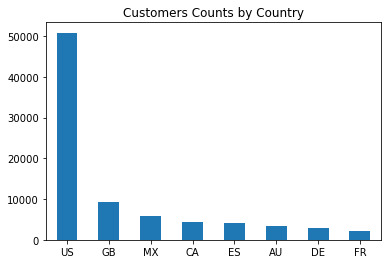

In [13]:
# Plot country counts
plt.plot()
df['country'].value_counts().plot(kind='bar', title='Customers Counts by Country')
plt.xticks(rotation=0)

# Calculate conversion rate by country
p = df.pivot_table(index='country', values='customer', aggfunc={'customer': ['count', 'mean']}).reset_index()
p['cnt_con'] = p['count'] / p['count'].sum()    

# Create pivot table with counts
p = p[['country', 'count', 'cnt_con', 'mean']]
p.rename(index=str, columns={'mean': 'conversion rate', 'cnt_con': '%'}, inplace=True)
display(p.round({'cnt_con': 3, 'conversion rate': 3}).sort_values(by='conversion rate', ascending=False))

60% of all customers are from the US. When looking at the conversion rates, most countries are relatively equal, with slightly lower rates for Spain and Mexico. While country of origin may not likely explain convergence, it's a good control variable for the model.

## Data Cleaning

In [14]:
def cleaning(df):
    # Remove irrelevant attributes
    df = df.drop('user_id', axis = 1) 
    
    # Min-max scale age 
    scaler = MinMaxScaler()
    df['age'] = scaler.fit_transform(pd.DataFrame(df['age']))
   
    # Loop attributes to create dummy variables
    for i in df.columns: 
        if df[i].dtype == "O":
            df = pd.concat([df, pd.get_dummies(df[i], prefix = i)], axis=1)
            del df[i] #delete the original object column
    
    # Identify X and y 
    if 'customer' in df.columns: 
        y = df["customer"]
        X = df.drop(["customer"], axis = 1)
        return X, y
    else:
        return df

In [15]:
# Create X,y
X, y = cleaning(df)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82908 entries, 0 to 82907
Data columns (total 26 columns):
age                            82908 non-null float64
channel_00 Organic             82908 non-null uint8
channel_11 FB                  82908 non-null uint8
channel_12 PINTEREST           82908 non-null uint8
channel_21 ASA                 82908 non-null uint8
channel_22 Adwords (Search)    82908 non-null uint8
channel_31 OUTBRAIN            82908 non-null uint8
channel_32 Taboola             82908 non-null uint8
channel_41 Youtube             82908 non-null uint8
channel_42 Adcolony            82908 non-null uint8
channel_61 Web/Content         82908 non-null uint8
channel_62 Social Media        82908 non-null uint8
channel_69 Others              82908 non-null uint8
channel_95 LAT                 82908 non-null uint8
os_android                     82908 non-null uint8
os_ios                         82908 non-null uint8
gender_female                  82908 non-null uint8
gende

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Model Parameter Optimization

Because the DV is binary, we use a sigmoidal logistic function for modeling purposes, although several classifiers could be used for further model fit comparison (Random Forest, MLP, GradientBoosting).

In [18]:
# Fit the model and model parameters
classifier = LogisticRegression()
classifier.fit(X_train, y_train.ravel())
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

# Set default metric to optimize over grid parameters: accuracy
opt = GridSearchCV(classifier, param_grid = param_grid, scoring = 'roc_auc')
opt.fit(X_train, y_train.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [19]:
# Create array with 1 and 0 for the prediction
y_pred = opt.predict(X_test)  
print('Grid best parameter (max. accuracy): ', opt.best_params_)
print('Grid best score (AUC_ROC): ', opt.best_score_)
print('Test score (accuracy): ', (y_pred == y_test).mean())

Grid best parameter (max. accuracy):  {'C': 1000}
Grid best score (AUC_ROC):  0.630136469541
Test score (accuracy):  0.70546375588


In [20]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.71      0.97      0.82     17447
          1       0.54      0.08      0.15      7426

avg / total       0.66      0.71      0.62     24873



Overall, model accuracy is roughly 70%, although the f1-score is rather low. This is most likely due to the minimal variation covered by the few attributes given. See next steps for further suggestions to improve model fit.

## Prediction

In [21]:
#Load the test_data.csv file
df_test = pd.read_csv('/Users/wiseer85/Desktop/test_data.csv_fixed')
df_test.head()

,user_id,channel,age,os,gender,country
0,0,42 Adcolony,32,android,female,US
1,1,12 PINTEREST,27,android,female,US
2,2,00 Organic,36,ios,male,GB
3,3,42 Adcolony,29,ios,female,US
4,4,12 PINTEREST,20,ios,female,CA


In [22]:
# Clean test data set
df_test_final = cleaning(df_test)

In [23]:
# Predict y
predict = opt.predict(df_test_final)

In [24]:
#Create a new column on the original test_data.csv file
df_test['customer'] = predict

In [25]:
# Save the file
df_test.to_csv('/Users/wiseer85/Desktop/wise_predictions.csv')

In [26]:
# Check saved file
pd.read_csv('/Users/wiseer85/Desktop/wise_predictions.csv').head(5)

,Unnamed: 0,user_id,channel,age,os,gender,country,customer
0,0,0,42 Adcolony,32,android,female,US,0
1,1,1,12 PINTEREST,27,android,female,US,0
2,2,2,00 Organic,36,ios,male,GB,0
3,3,3,42 Adcolony,29,ios,female,US,0
4,4,4,12 PINTEREST,20,ios,female,CA,0


## Next Steps

- Apply sampling techique
- Consider additional features 
- Explore possible interactions between features
- Use alternative classifiers for model fit comparison 
- Try other tools for optimizing hyperparameters
- Explore coefficients for further understanding of features